In [9]:
import random
import numpy as np
import pandas as pd
import torch
from torch.utils.data import DataLoader

import sys
import os
# Get the parent directory of train/Synthetic_Data_Generator
parent_dir = os.path.abspath(os.path.join(os.getcwd(), "../../"))
sys.path.append(parent_dir)
from train.utils import EnhancerDataset
from train import interpretation
from model.model import ExplaiNN3
from scripts.synthetic_prediction import generate_synthetic_distance_data, motif_score_prediction,extract_pwm_from_meme

# Learn What TFs Contribute Most To Prediction

In [3]:
# File path
file_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_all_results_rep1/importance/GFP_sorted_tf_order.txt'
file_path2 = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_all_results_rep1/importance/GFP+_sorted_tf_order.txt'
file_path3 = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_all_results_rep1/importance/GFP-_sorted_tf_order.txt'

# Read the file and filter lines that contain '-'
with open(file_path, 'r') as f:
    lines = f.readlines()

# Filter lines that contain the '-' character
filtered_lines = [line.strip() for line in lines if '-' in line]

# Get the top 10 elements that contain '-'
top_10_lines = filtered_lines[:8] + filtered_lines[-9:]

# Output the result
print("Top 10 elements that contain '-' :")
for i, line in enumerate(top_10_lines, 1):
    print(f"{i}: {line}")

Top 10 elements that contain '-' :
1: AC0069(Pax4)-f0
2: AC0069(Pax4)-f79
3: AC0069(Pax4)-f36
4: AC0069(Pax4)-f16
5: AC0069(Pax4)-f31
6: AC0069(Pax4)-f84
7: AC0069(Pax4)-f86
8: AC0072(NFATC2)-f22
9: AC0073/AC0065(Prdm5/Klf4)-f61
10: AC0052(Bcl11B)-f64
11: AC0069(Pax4)-f21
12: AC0002(Irf1)-f44
13: AC0069(Pax4)-f75
14: AC0069(Pax4)-f76
15: AC0069(Pax4)-f8
16: AC0069(Pax4)-f14
17: AC0069(Pax4)-f82


In [5]:
with open(file_path2, 'r') as f:
    lines = f.readlines()

# Filter lines that contain the '-' character
filtered_lines = [line.strip() for line in lines if '-' in line]

# Get the top 10 elements that contain '-'
top_10_lines = filtered_lines[:10]

# Output the result
print("Top 10 elements that contain '-' :")
for i, line in enumerate(top_10_lines, 1):
    print(f"{i}: {line}")

Top 10 elements that contain '-' :
1: AC0073/AC0002(Prdm5/Stat2)-f33
2: AC0069(Pax4)-f54
3: AC0069(Pax4)-f41
4: AC0070(SP1)-f67
5: AC0069(Pax4)-f0
6: AC0069(Pax4)-f16
7: AC0069(Pax4)-f31
8: AC0069(Pax4)-f36
9: AC0069(Pax4)-f84
10: AC0069(Pax4)-f3


In [6]:
with open(file_path3, 'r') as f:
    lines = f.readlines()

# Filter lines that contain the '-' character
filtered_lines = [line.strip() for line in lines if '-' in line]

# Get the top 10 elements that contain '-'
top_10_lines = filtered_lines[:10]

# Output the result
print("Top 10 elements that contain '-' :")
for i, line in enumerate(top_10_lines, 1):
    print(f"{i}: {line}")

Top 10 elements that contain '-' :
1: AC0073/AC0065(Prdm5/Klf4)-f61
2: AC0002(Irf1)-f44
3: AC0069(Pax4)-f28
4: AC0069(Pax4)-f82
5: AC0069(Pax4)-f14
6: AC0069(Pax4)-f75
7: AC0069(Pax4)-f56
8: AC0069(Pax4)-f2
9: AC0069(Pax4)-f36
10: AC0069(Pax4)-f8


# Generate Synthetic Data and Test Motif Distance

In [5]:
seed = 42 
batch = 322
num_cnns = 90
learning_rate = 4e-4
filter_size = 19
weight_file = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_all_results_rep1/best_r2_best_pearson_model_epoch_54.pth'
target_labels = ['GFP+','GFP-','GFP']
meme_file_dir = '/pmglocal/ty2514/Enhancer/motif-clustering/databases/jaspar2024/JASPAR2024_CORE_vertebrates_mus_musculus_non-redundant_pfms_meme.meme'
output_pickle_file = '/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator/90nn_all_synthetic_seq_dist.pkl'

In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model without moving it to the device yet
explainn = ExplaiNN3(num_cnns = num_cnns, input_length = 608, num_classes = 3, 
                 filter_size = 19, num_fc=2, pool_size=7, pool_stride=7, 
                 drop_out = 0.3, weight_path = None)# Training

# Load the model weights conditionally based on GPU availability
if torch.cuda.is_available():
    explainn.load_state_dict(torch.load(weight_file))
    print('explainn loaded on GPU')
else:
    explainn.load_state_dict(torch.load(weight_file, map_location=torch.device('cpu')))
    print('explainn loaded on CPU')
# Move the model to the appropriate device after loading the weights
explainn.to(device)
explainn.eval()
print('\n')

explainn loaded on GPU




In [31]:
### GFP: (pos) AC0069, AC0072 (neg) AC0069, AC0002
### GFP +: (pos) AC0073/AC0002, AC0069, AC0070
### GFP -: (pos) AC0073/AC0065, AC0002, AC0069

cluster_results = pd.read_csv("/pmglocal/ty2514/Enhancer/motif-clustering/JASPAR2024_mus_musculus_non-redundant_results/metadata.tsv",
                                        sep="\t",comment="#")
cluster_results[cluster_results['cluster'] == 'AC0065']

,motif_id,cluster,source_id,tf_name,family_name,motif_type,PMID
11,MA0039.1,AC0065,MA0039.1,Klf4,['C2H2 zinc finger factors'],Unknown,9443972


In [7]:
# AC0069: 'MA0068.1'
# AC0073: 'MA1999.1'
# AC0070: 'MA0079.2'
# AC0002: 'MA0050.3'
# AC0065: 'MA0039.1
df = generate_synthetic_distance_data(200, ['MA0068.1','MA0050.3'],meme_file_dir,output_pickle_file,distance = 10, replicate=5,save_plot = False)
result_df = motif_score_prediction(model = explainn, df = df, device = device, batch = batch, target_labels=target_labels)

PWM for MA0068.1 has length: 30
MA0068.1: GAAAAATTTCCAATACTCCACTCCCCCCCC
PWM for MA0050.3 has length: 15
MA0050.3: AATGAAACTGAAAGT


Motif A GAAAAATTTCCAATACTCCACTCCCCCCCC has 18 200nt DNA segments, inserted with distance 10
Motif B AATGAAACTGAAAGT has 19 200nt DNA segments, inserted with distance 10


In [35]:
result_df_without_sequence = result_df.drop(columns=['sequence'])
output = os.path.join('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator','AC0073_AC0002_GFP-.csv')
result_df_without_sequence.to_csv(output, index=False)


In [36]:
result_df_without_sequence

,name,motif_distance_score,replicate,GFP+,GFP-,GFP
0,CTGTTCTCCATCTCC_0_AATGAAACTGAAAGT_0_random_dna,189,0,5.583447,5.219699,0.164123
1,CTGTTCTCCATCTCC_0_random_dna_AATGAAACTGAAAGT_0,393,0,4.498604,4.885228,-0.230694
2,CTGTTCTCCATCTCC_0_AATGAAACTGAAAGT_10_random_dna,199,0,5.689044,5.262295,0.194244
3,CTGTTCTCCATCTCC_0_random_dna_AATGAAACTGAAAGT_10,403,0,4.740471,5.180459,-0.220000
4,CTGTTCTCCATCTCC_0_AATGAAACTGAAAGT_20_random_dna,209,0,5.635405,5.427056,0.078718
...,...,...,...,...,...,...
3605,CTGTTCTCCATCTCC_180_random_dna_AATGAAACTGAAAGT...,373,4,6.401166,6.401503,0.130196
3606,CTGTTCTCCATCTCC_180_AATGAAACTGAAAGT_170_random...,179,4,5.828458,5.704378,0.179168
3607,CTGTTCTCCATCTCC_180_random_dna_AATGAAACTGAAAGT...,383,4,6.385220,6.398138,0.107683
3608,CTGTTCTCCATCTCC_180_AATGAAACTGAAAGT_180_random...,189,4,5.790849,5.629434,0.206032


In [11]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from Bio import motifs
from Bio.Seq import Seq

def plot_normalized_correlations(csv_file_path):
    """
    This function takes the path to a CSV file, normalizes the 'motif_distance_score'
    and GFP-related columns, calculates the correlations between them, and plots the
    normalized scatter plots.

    Args:
    - csv_file_path (str): Path to the CSV file containing the data.

    Returns:
    - None
    """
    # Load the CSV file
    df = pd.read_csv(csv_file_path)

    # Drop 'sequence' column if it exists
    if 'sequence' in df.columns:
        df = df.drop(columns=['sequence'])

    # Group by 'name' to get the mean of GFP+, GFP-, and GFP, and ensure the motif_distance_score is the same across replicates
    grouped_df = df.groupby('name').agg({
        'motif_distance_score': 'first',  # Take the first value of motif_distance_score (as it's consistent across replicates)
        'GFP+': 'mean',
        'GFP-': 'mean',
        'GFP': 'mean'
    }).reset_index()

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Normalize motif_distance_score to the range [0, 1]
    grouped_df['motif_distance_score_normalized'] = scaler.fit_transform(grouped_df[['motif_distance_score']])

    # Normalize GFP+, GFP-, and GFP to the range [0, 1]
    grouped_df['GFP+_normalized'] = scaler.fit_transform(grouped_df[['GFP+']])
    grouped_df['GFP-_normalized'] = scaler.fit_transform(grouped_df[['GFP-']])
    grouped_df['GFP_normalized'] = scaler.fit_transform(grouped_df[['GFP']])

    # Calculate correlation between normalized motif_distance_score and normalized GFP values
    corr_gfp_plus, _ = pearsonr(grouped_df['motif_distance_score_normalized'], grouped_df['GFP+_normalized'])
    corr_gfp_minus, _ = pearsonr(grouped_df['motif_distance_score_normalized'], grouped_df['GFP-_normalized'])
    corr_gfp, _ = pearsonr(grouped_df['motif_distance_score_normalized'], grouped_df['GFP_normalized'])

    # Print correlation values
    print(f"Correlation between normalized motif_distance_score and normalized GFP+: {corr_gfp_plus:.2f}")
    print(f"Correlation between normalized motif_distance_score and normalized GFP-: {corr_gfp_minus:.2f}")
    print(f"Correlation between normalized motif_distance_score and normalized GFP: {corr_gfp:.2f}")

    # Plot scatter plot with smaller dots and normalized values
    plt.figure(figsize=(15, 5))

    # GFP+
    plt.subplot(1, 3, 1)
    plt.scatter(grouped_df['motif_distance_score_normalized'], grouped_df['GFP+_normalized'], color='blue', alpha=0.6, s=20)
    plt.title(f'GFP+ (r={corr_gfp_plus:.2f})')
    plt.xlabel('Normalized Motif Distance Score')
    plt.ylabel('Normalized Mean GFP+')

    # GFP-
    plt.subplot(1, 3, 2)
    plt.scatter(grouped_df['motif_distance_score_normalized'], grouped_df['GFP-_normalized'], color='green', alpha=0.6, s=20)
    plt.title(f'GFP- (r={corr_gfp_minus:.2f})')
    plt.xlabel('Normalized Motif Distance Score')
    plt.ylabel('Normalized Mean GFP-')

    # GFP
    plt.subplot(1, 3, 3)
    plt.scatter(grouped_df['motif_distance_score_normalized'], grouped_df['GFP_normalized'], color='red', alpha=0.6, s=20)
    plt.title(f'GFP (r={corr_gfp:.2f})')
    plt.xlabel('Normalized Motif Distance Score')
    plt.ylabel('Normalized Mean GFP')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_normalized_correlations_with_fit(csv_file_path, poly_order=1):
    """
    This function takes the path to a CSV file, normalizes the 'motif_distance_score'
    and GFP-related columns, calculates the correlations between them, and plots the
    normalized scatter plots with a fitted line or curve.
    
    Args:
    - csv_file_path (str): Path to the CSV file containing the data.
    - poly_order (int): The order of the polynomial for curve fitting. Default is 1 (linear regression).
    
    Returns:
    - None
    """
    # Load the CSV file
    df = pd.read_csv(csv_file_path)

    # Drop 'sequence' column if it exists
    if 'sequence' in df.columns:
        df = df.drop(columns=['sequence'])

    # Group by 'name' to get the mean of GFP+, GFP-, and GFP, and ensure the motif_distance_score is the same across replicates
    grouped_df = df.groupby('name').agg({
        'motif_distance_score': 'first',  # Take the first value of motif_distance_score (as it's consistent across replicates)
        'GFP+': 'mean',
        'GFP-': 'mean',
        'GFP': 'mean'
    }).reset_index()

    # Initialize MinMaxScaler
    scaler = MinMaxScaler()

    # Normalize motif_distance_score to the range [0, 1]
    grouped_df['motif_distance_score_normalized'] = scaler.fit_transform(grouped_df[['motif_distance_score']])

    # Normalize GFP+, GFP-, and GFP to the range [0, 1]
    grouped_df['GFP+_normalized'] = scaler.fit_transform(grouped_df[['GFP+']])
    grouped_df['GFP-_normalized'] = scaler.fit_transform(grouped_df[['GFP-']])
    grouped_df['GFP_normalized'] = scaler.fit_transform(grouped_df[['GFP']])

    # Calculate correlation between normalized motif_distance_score and normalized GFP values
    corr_gfp_plus, _ = pearsonr(grouped_df['motif_distance_score_normalized'], grouped_df['GFP+_normalized'])
    corr_gfp_minus, _ = pearsonr(grouped_df['motif_distance_score_normalized'], grouped_df['GFP-_normalized'])
    corr_gfp, _ = pearsonr(grouped_df['motif_distance_score_normalized'], grouped_df['GFP_normalized'])

    # Print correlation values
    print(f"Correlation between normalized motif_distance_score and normalized GFP+: {corr_gfp_plus:.2f}")
    print(f"Correlation between normalized motif_distance_score and normalized GFP-: {corr_gfp_minus:.2f}")
    print(f"Correlation between normalized motif_distance_score and normalized GFP: {corr_gfp:.2f}")

    # Function to fit a line or curve
    def plot_with_fit(x, y, title, ax, color):
        # Scatter plot
        ax.scatter(x, y, color=color, alpha=0.6, s=20)
        
        # Fit a polynomial curve of degree `poly_order`
        poly_coeffs = np.polyfit(x, y, poly_order)
        poly_func = np.poly1d(poly_coeffs)
        
        # Plot the fitted line or curve
        x_vals = np.linspace(x.min(), x.max(), 100)
        y_vals = poly_func(x_vals)
        ax.plot(x_vals, y_vals, color=color, linestyle='--', label=f'Poly (degree={poly_order}) fit')
        
        # Add title and labels
        ax.set_title(title)
        ax.set_xlabel('Normalized Motif Distance Score')
        ax.set_ylabel('Normalized GFP Value')
        ax.legend()

    # Plot scatter plots with fitted curves/lines
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # GFP+
    plot_with_fit(grouped_df['motif_distance_score_normalized'], grouped_df['GFP+_normalized'],
                  f'GFP+ (r={corr_gfp_plus:.2f})', axes[0], color='blue')

    # GFP-
    plot_with_fit(grouped_df['motif_distance_score_normalized'], grouped_df['GFP-_normalized'],
                  f'GFP- (r={corr_gfp_minus:.2f})', axes[1], color='green')

    # GFP
    plot_with_fit(grouped_df['motif_distance_score_normalized'], grouped_df['GFP_normalized'],
                  f'GFP (r={corr_gfp:.2f})', axes[2], color='red')

    # Adjust layout for better visualization
    plt.tight_layout()

    # Show the plot
    plt.show()

def rank_sequences_by_pwm_distance(csv_file_path, pwm1, pwm2):
    """
    Reads in a CSV file containing sequences, scores the sequences against two PWMs,
    calculates the distance between the best matches for each PWM, and ranks the
    sequences based on the distance between the motifs.

    Args:
    - csv_file_path (str): Path to the CSV file.
    - pwm1 (motifs.Motif): The first PWM motif object.
    - pwm2 (motifs.Motif): The second PWM motif object.

    Returns:
    - None
    """
    # Read the CSV file, assuming the second column contains the sequences
    df = pd.read_csv(csv_file_path)

    # Initialize a list to store the sample number and the distance between PWM matches
    results = []

    # Loop over each sequence and calculate the distance between the PWM matches
    for index, row in df.iterrows():
        sample_number = row[0]  # Get the sample number (e.g., 00, 01)
        sequence = row[2]  # Get the sequence string
        
        # Convert the sequence to a Bio.Seq object
        seq = Seq(sequence)
        
        # Find the best match positions for each PWM
        best_pwm1_pos, best_pwm1_score = find_best_match(pwm1, seq)
        best_pwm2_pos, best_pwm2_score = find_best_match(pwm2, seq)
        
        # Ensure both motifs are found (i.e., a valid match)
        if best_pwm1_pos != -1 and best_pwm2_pos != -1:
            # Calculate the absolute distance between the two best motif positions
            distance = abs(best_pwm1_pos - best_pwm2_pos)
            results.append((sample_number, distance))
        else:
            # Handle the case where one or both motifs do not have valid matches
            results.append((sample_number, float('inf')))  # Use infinity for not found motifs

    # Sort the results by distance (smallest to largest)
    sorted_results = sorted(results, key=lambda x: x[1])

    # Print out the sorted sample numbers and distances
    print(f"{'Sample Number':<15}{'Distance Between Motifs'}")
    print("-" * 40)
    for sample_number, distance in sorted_results:
        if distance == float('inf'):
            print(f"{sample_number:<15}Motif(s) not found")
        else:
            print(f"{sample_number:<15}{distance}")

def find_best_match(pwm, sequence):
    """
    Find the best match for a PWM in a given sequence.

    Args:
    - pwm (motifs.Motif): The PWM motif object.
    - sequence (Bio.Seq.Seq): The sequence to scan.

    Returns:
    - (best_position, best_score): The best match position and score.
    """
    # Score the sequence with the PWM
    scores = pwm.scanPWM(sequence)
    
    # Find the best match position (highest score)
    best_score = max(scores)
    best_position = scores.index(best_score) if best_score > 0 else -1
    
    return best_position, best_score





Correlation between normalized motif_distance_score and normalized GFP+: -0.49
Correlation between normalized motif_distance_score and normalized GFP-: -0.26
Correlation between normalized motif_distance_score and normalized GFP: -0.48


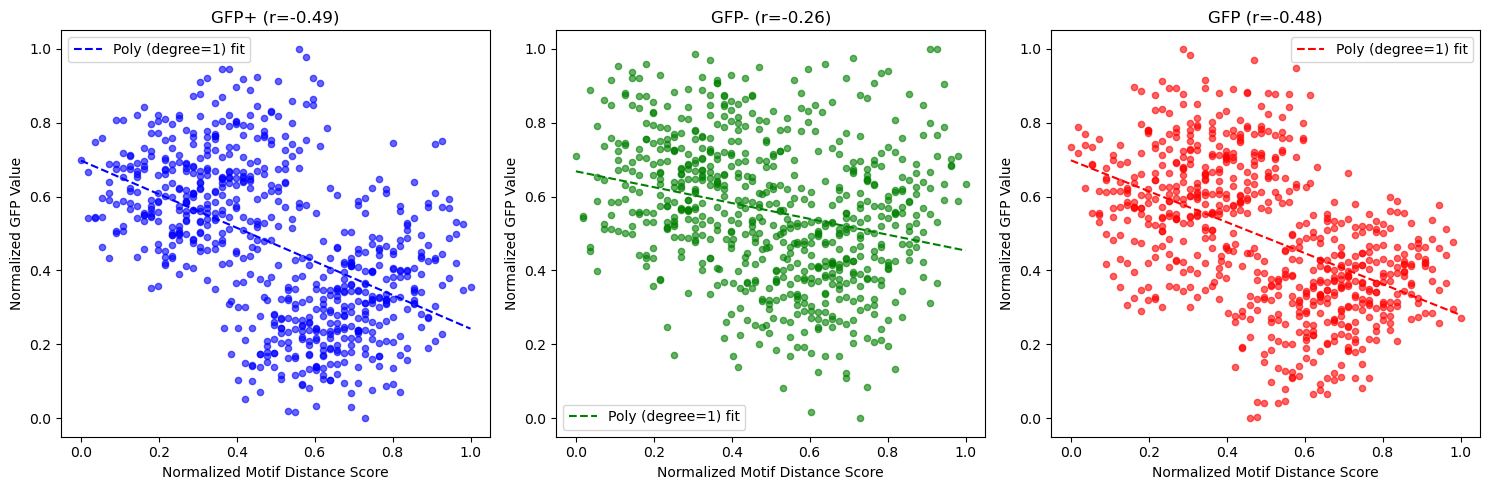

PWM for MA0068.1 has length: 30
PWM for MA0050.3 has length: 15


/tmp/ipykernel_1082404/3193141062.py:199: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sample_number = row[0]  # Get the sample number (e.g., 00, 01)
/tmp/ipykernel_1082404/3193141062.py:200: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sequence = row[2]  # Get the sequence string


AttributeError: 'list' object has no attribute 'scanPWM'

In [12]:
#plot_normalized_correlations('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator/AC0069_AC0002_GFP.csv')
plot_normalized_correlations_with_fit('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator/AC0069_AC0002_GFP.csv')

# Example usage:
csv_file_path = '/pmglocal/ty2514/Enhancer/Enhancer/data/fragment_sequences.csv'
pwm1 = extract_pwm_from_meme(meme_file_dir, 'MA0068.1')
pwm2 = extract_pwm_from_meme(meme_file_dir, 'MA0050.3')
rank_sequences_by_pwm_distance(csv_file_path, pwm1, pwm2)

In [14]:
pwm1.shape

AttributeError: 'list' object has no attribute 'shape'

Correlation between normalized motif_distance_score and normalized GFP+: -0.32
Correlation between normalized motif_distance_score and normalized GFP-: 0.11
Correlation between normalized motif_distance_score and normalized GFP: -0.69


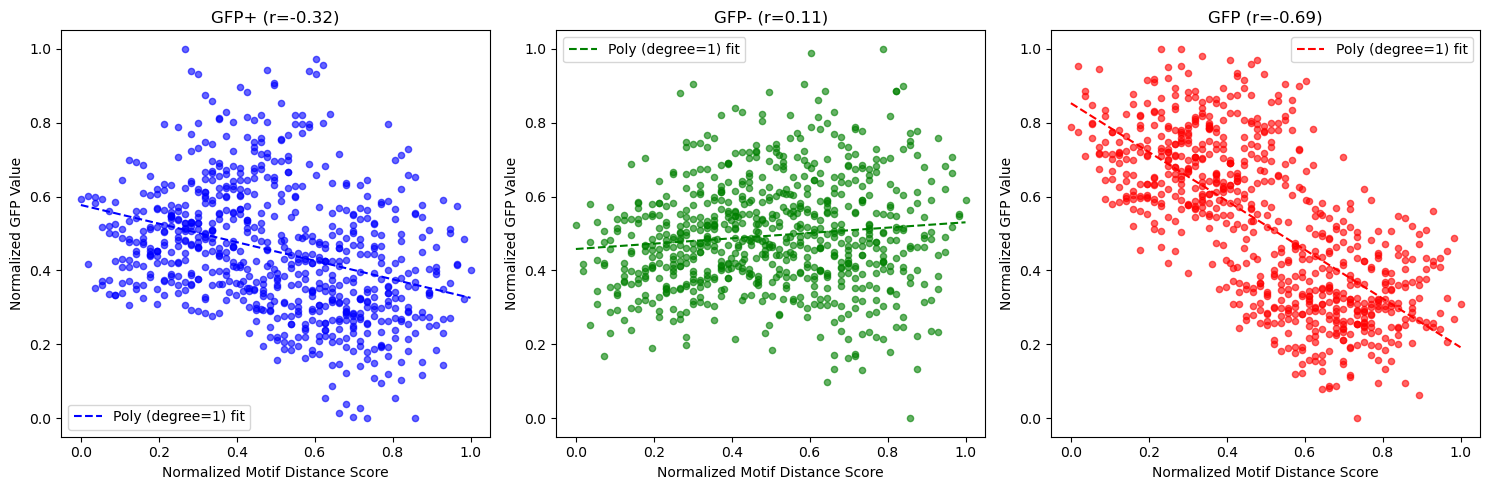

In [55]:
#plot_normalized_correlations('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator/AC0069_AC0070_GFP+.csv')
plot_normalized_correlations_with_fit('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator/AC0069_AC0070_GFP+.csv')

Correlation between normalized motif_distance_score and normalized GFP+: 0.78
Correlation between normalized motif_distance_score and normalized GFP-: 0.78
Correlation between normalized motif_distance_score and normalized GFP: -0.55


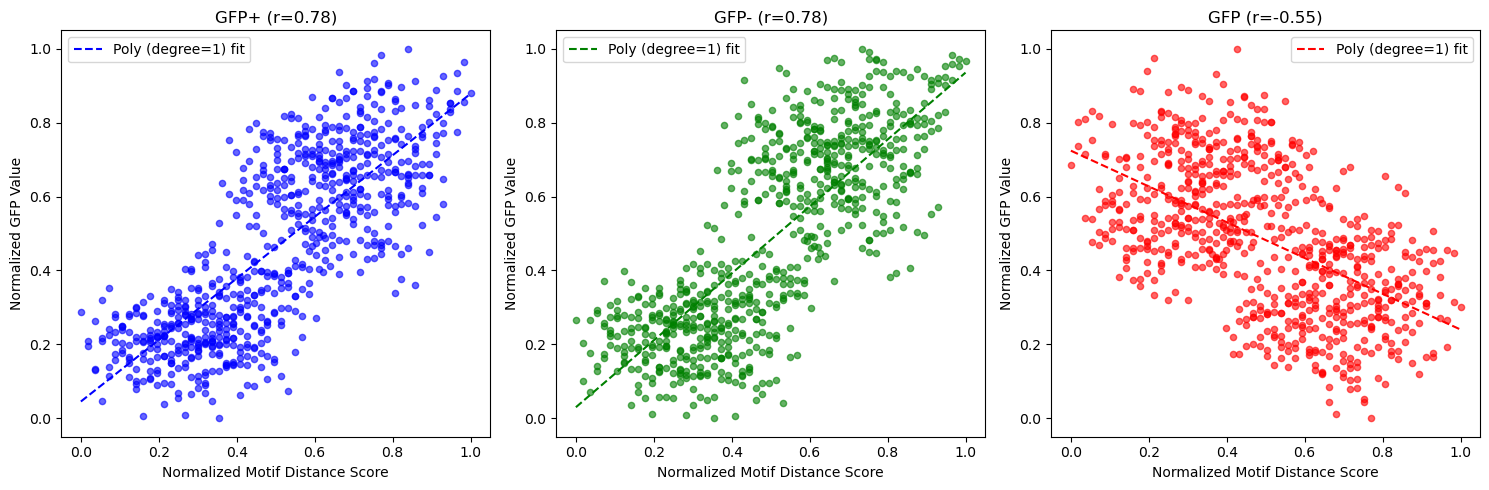

In [56]:
plot_normalized_correlations_with_fit('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator/AC0069_AC0072_GFP.csv')

Correlation between normalized motif_distance_score and normalized GFP+: 0.45
Correlation between normalized motif_distance_score and normalized GFP-: 0.10
Correlation between normalized motif_distance_score and normalized GFP: 0.37


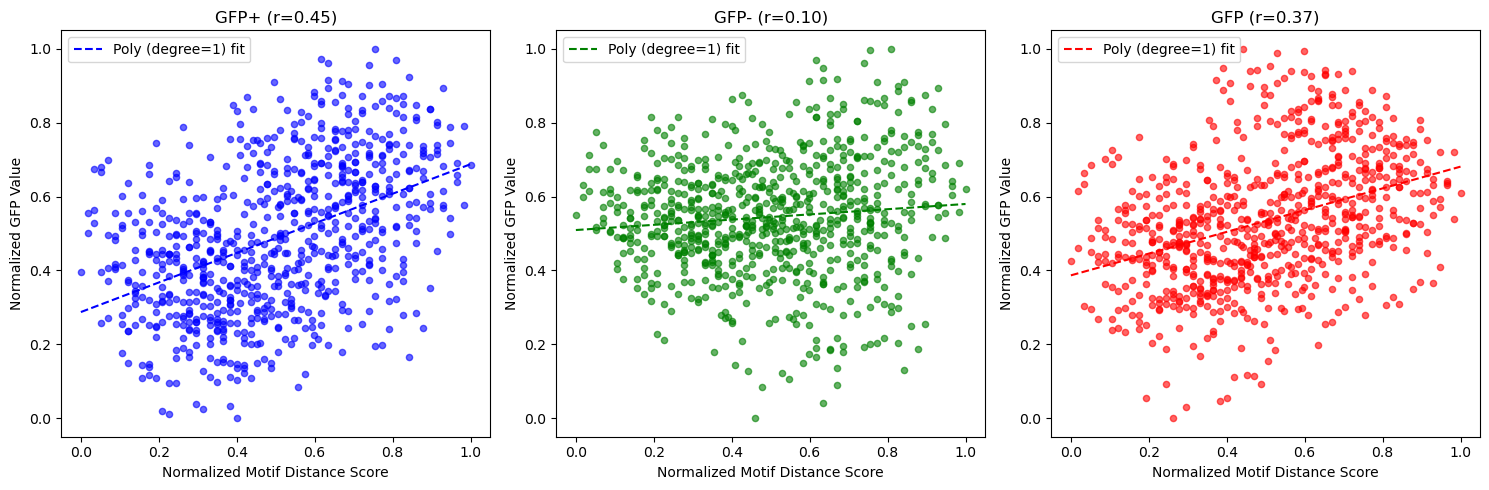

In [57]:
plot_normalized_correlations_with_fit('/pmglocal/ty2514/Enhancer/Enhancer/train/Synthetic_Data_Generator/AC0072_AC0002_GFP.csv')

# Interpretation

In [4]:
cluster_results = pd.read_csv("/pmglocal/ty2514/Enhancer/motif-clustering/JASPAR2024_mus_musculus_non-redundant_results/metadata.tsv",
                                        sep="\t",comment="#")
tomtom_results = pd.read_csv("/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_results/tomtom_results/tomtom.tsv",
                                        sep="\t",comment="#")
filters_with_min_q = tomtom_results.groupby('Query_ID').min()["q-value"]
tomtom_results = tomtom_results[["Target_ID", "Query_ID", "q-value"]]
tomtom_results = tomtom_results[tomtom_results["q-value"]<0.05]

motif_to_cluster = cluster_results.set_index('motif_id')['cluster'].to_dict()
motif_to_tf_name = cluster_results.set_index('motif_id')['tf_name'].to_dict()
motif_to_family_name = cluster_results.set_index('motif_id')['family_name'].to_dict()
filters = tomtom_results["Query_ID"].unique()

# Assuming `annotation` is already populated
annotation_data = []

for f in filters:
    t = tomtom_results[tomtom_results["Query_ID"] == f]
    target_id = t["Target_ID"]

    if len(target_id) > 5:
        target_id = target_id[:5]

    # Join Unique annotations by '/'
    cluster = "/".join({motif_to_cluster[i]: i for i in target_id.values})
    tf_name = "/".join({motif_to_tf_name[i]: i for i in target_id.values})
    family_name = "/".join({motif_to_family_name[i]: i for i in target_id.values})

    # Append the data to the list
    annotation_data.append({
        'filter': f,
        'cluster': cluster,
        'tf_name': tf_name,
        'family_name': family_name
    })

# Create a DataFrame from the collected data
annotation_df = pd.DataFrame(annotation_data)

# Display the resulting DataFrame
annotation_df.iloc[:5,:]


,filter,cluster,tf_name,family_name
0,filter2,AC0069,Pax4,['Paired box factors']
1,filter6,AC0069,Pax4,['Paired box factors']
2,filter7,AC0066,Gli1/Gli2,['C2H2 zinc finger factors']
3,filter8,AC0069,Pax4,['Paired box factors']
4,filter10,AC0069,Pax4,['Paired box factors']


In [5]:
weights = explainn.final.weight.detach().cpu().numpy()
print(f'weight_df has shape: {weights.shape} (number of labels, number of fileters)')
filters = ["f"+str(i) for i in range(num_cnns)]
print(filters)
for index,row in annotation_df.iterrows():
    filter = row['filter']
    split_string = filter.split('filter', 1)
    # change 'filter{i}' to 'f{i}'. e.g. filter20 -> f20
    new_filter_name = 'f' + split_string[1].strip()
    # Check if filter is in the filters list
    if new_filter_name in filters:
        # Find the index of the element to be replaced
        index_to_replace = filters.index(new_filter_name)
        # Replace the element in the filters list
        filters[index_to_replace] = f"{row['cluster']}({row['tf_name']})-{new_filter_name}"


#for i in annotation.keys():
#    filters[int(i.split("filter")[-1])] = annotation[i]
weight_df = pd.DataFrame(weights, target_labels, columns=filters)
#result_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_results'
#weight_file_dir = os.path.join(result_dir, 'filter_weights.csv')
# Save the DataFrame to a CSV file
#weight_df.to_csv(weight_file_dir, index=True)  # Set index=True if you want to save the index
weight_df

weight_df has shape: (2, 90) (number of labels, number of fileters)
['f0', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7', 'f8', 'f9', 'f10', 'f11', 'f12', 'f13', 'f14', 'f15', 'f16', 'f17', 'f18', 'f19', 'f20', 'f21', 'f22', 'f23', 'f24', 'f25', 'f26', 'f27', 'f28', 'f29', 'f30', 'f31', 'f32', 'f33', 'f34', 'f35', 'f36', 'f37', 'f38', 'f39', 'f40', 'f41', 'f42', 'f43', 'f44', 'f45', 'f46', 'f47', 'f48', 'f49', 'f50', 'f51', 'f52', 'f53', 'f54', 'f55', 'f56', 'f57', 'f58', 'f59', 'f60', 'f61', 'f62', 'f63', 'f64', 'f65', 'f66', 'f67', 'f68', 'f69', 'f70', 'f71', 'f72', 'f73', 'f74', 'f75', 'f76', 'f77', 'f78', 'f79', 'f80', 'f81', 'f82', 'f83', 'f84', 'f85', 'f86', 'f87', 'f88', 'f89']


,f0,f1,AC0069(Pax4)-f2,f3,f4,f5,AC0069(Pax4)-f6,AC0066(Gli1/Gli2)-f7,AC0069(Pax4)-f8,f9,...,f80,f81,f82,f83,AC0069(Pax4)-f84,f85,f86,f87,AC0069(Pax4)-f88,f89
GFP+,0.081534,0.181157,0.248874,0.181560,0.002539,0.047324,0.237871,0.110817,0.233839,0.033559,...,0.212228,0.115420,0.157949,0.121214,0.217157,0.134688,0.163591,0.001927,0.169545,-0.001799
GFP-,0.000444,0.083332,0.188044,0.242838,0.058648,0.123694,0.170986,0.155349,0.080560,0.121754,...,0.099247,0.197698,0.133829,0.035363,0.230519,0.041809,0.102332,0.035025,0.165388,-0.024118


In [6]:
import matplotlib.pyplot as plt
import math
import pandas as pd

def plot_filter_weight(weight_df, dir_save_plot):
    num_cnns = weight_df.shape[1]  # Assuming number of columns represents CNNs
    
    # Loop through each row to create a separate plot
    for index, row in weight_df.iterrows():
        # Sort the row in descending order by weight values
        sorted_row = row.sort_values(ascending=False)

        # Extract labels (column names, now sorted) and values (sorted weights)
        labels = sorted_row.index
        values = sorted_row.values

        # Calculate min and max values for the x-axis range
        min_value = values.min()
        max_value = values.max()

        # Define colors for the bars based on a condition (customize as needed)
        colors = ['royalblue' if '-' not in label.lower() else 'red' for label in labels]

        # Create a new figure for each row
        plt.figure(figsize=(8, math.ceil(0.15 * num_cnns)))

        # Plot the bar chart for this row
        plt.barh(labels, values, color=colors)
        plt.title(f'Weights for Target: {index}')
        plt.xlabel('Weight')
        plt.ylabel('Filters')

        # Invert y-axis to have the highest value at the top
        plt.gca().invert_yaxis()

        # Set x-axis limits
        plt.xlim(min_value - 0.05, max_value + 0.05)

        # Annotate the value next to each bar
        for i, (label, value) in enumerate(zip(labels, values)):
            if value >= 0:
                plt.text(value, i, f'{value:.3f}', va='center', ha='left', fontsize=10)
            else:
                plt.text(value, i, f'{value:.3f}', va='center', ha='right', fontsize=10)

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()

        # Save the individual plot to the specified directory
        plot_filename = f'{dir_save_plot}/filter_weights_{index}.png'
        # plt.savefig(plot_filename)
        print(f'Saved plot for {index} at {plot_filename}')

        # Optionally close the plot after saving to free up memory
        # plt.close()


In [7]:
# Plotting
#plot_filter_weight(weight_df,'asdf')
annotated_weight_df = weight_df.loc[:, weight_df.columns.str.contains('-')]
#plot_filter_weight(annotated_weight_df,'asdf')

In [8]:
upper_bound = 0.25
input_data_dir = '/pmglocal/ty2514/Enhancer/Enhancer/data/input_data.csv'
df = pd.read_csv(input_data_dir)
dataset = EnhancerDataset(df, feature_list=['G+','G-'], scale_mode = 'none')
# Prepare dataloader
dataset = DataLoader(dataset=dataset, batch_size=batch, shuffle=False)
# Running get_explainn_predictions function to get predictions and true labels for all sequences in the given data loader
predictions, labels = interpretation.get_explainn_predictions(dataset, explainn, device, isSigmoid=False)

# Calculate absolute residuals
residuals = np.abs(labels - predictions)

# Define the upper bound of residuals
print(f'Using Bound = {upper_bound} as a cutoff to select high confident predictions.')

# Create a mask for filtering out samples with low confident precition (abs(residual) > upper_bound)
mask = (residuals <= upper_bound).all(axis=1)
# Get sequences and labels from dataset
data_inp = []
data_out = []
# Iterate over the DataLoader
for batch_features, batch_labels in dataset:
    data_inp.append(batch_features)
    data_out.append(batch_labels)
# Concatenate all the batches into single tensors
data_inp = torch.cat(data_inp, dim=0)
data_out = torch.cat(data_out, dim=0)

# Use the mask to filter the predictions and labels
print(f'Total number of input samples: {len(data_inp)}')
data_inp = data_inp[mask]
data_out = data_out[mask]
print(data_inp.shape)
print(data_out.shape)

print(f'Number of input samples with high confident prediction: {len(data_inp)}')

# Create new dataloader with filtered high confident samples
dataset = torch.utils.data.TensorDataset(data_inp, data_out)
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch, shuffle=False,)



Using Bound = 0.25 as a cutoff to select high confident predictions.
Total number of input samples: 28800
torch.Size([21450, 4, 608])
torch.Size([21450, 2])
Number of input samples with high confident prediction: 21450


In [31]:
# Save the list of arrays to a file
import pickle
with open('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_results/importance/GFP+.pkl', 'wb') as f:
    pickle.dump(unit_importance_GFP_pos, f)

In [32]:

with open('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_results/importance/GFP+.pkl', 'rb') as f:
    a = pickle.load(f)


In [51]:
activations = np.load('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_results/Model_Activations.npy')
from tqdm import tqdm

importance_dict = {}
for label in target_labels:
    importance_dict[label] = []
# Use tqdm to track progress over the loop
for unit_index in tqdm(range(num_cnns), desc="Processing units"):
    # Calculate unit importance for the current unit
    unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
    importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, unit_index, target_labels)

    # Store the importance for each label
    for label in target_labels:
        importance_dict[label].append(importance[label])

Processing units: 100%|██████████| 90/90 [05:48<00:00,  3.87s/it]


In [9]:
# Assuming 'interpretation' and 'explainn' are already defined and properly configured
# Also assuming 'data_loader', 'device', and 'annotation' are defined as per your setup
activations = np.load('/pmglocal/ty2514/Enhancer/Enhancer/data/ExplaiNN_both_results/Model_Activations.npy')

unit_importance_GFP_pos = []
unit_importance_GFP_neg = []

# Loop through units with indices 0 to 4
for unit_index in range(num_cnns):
    print(unit_index)
    # Calculate unit importance for the current unit
    unit_outputs = interpretation.get_explainn_unit_outputs(data_loader, explainn, device)
    target_labels = ['GFP+','GFP-']
    importance = interpretation.get_specific_unit_importance(activations, explainn, unit_outputs, unit_index, target_labels)
    unit_importance_GFP_pos.append(importance['GFP+'])
    unit_importance_GFP_neg.append(importance['GFP-'])


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89


In [22]:
unit_names = list(weight_df.columns)
means = [np.mean(values) for values in unit_importance_GFP_neg]
sorted_data = sorted(zip(means, unit_names, unit_importance_GFP_neg), key=lambda x: x[0], reverse=True)
sorted_means, sorted_names, sorted_values = zip(*sorted_data)


90

In [49]:
import matplotlib.pyplot as plt
import numpy as np
import math

def plot_importance(unit_importance_values, unit_names, title_suffix, dir_save_plot, annotated_filter_only=False, num_tf_plotted=False):
    num_cnns = len(unit_importance_values)  # Use the length of unit importance values for dynamic plotting
    if num_tf_plotted and isinstance(num_tf_plotted, int):
        plt.figure(figsize=(8, math.ceil(0.4 * num_tf_plotted)))
    else:
        plt.figure(figsize=(8, math.ceil(0.2 * num_cnns)))

    # Calculate the means of each list in unit_importance_values
    means = [np.mean(values) for values in unit_importance_values]

    # Create tuples of means, unit names, and values, then sort them by means
    sorted_data = sorted(zip(means, unit_names, unit_importance_values), key=lambda x: x[0], reverse=True)

    # Unzip the sorted data
    sorted_means, sorted_names, sorted_values = zip(*sorted_data)

    # Filter if annotated_filter_only is True
    if annotated_filter_only:
        filtered_data = [(mean, name, values) for mean, name, values in zip(sorted_means, sorted_names, sorted_values) if '-' in name]
        if filtered_data:
            sorted_means, sorted_names, sorted_values = zip(*filtered_data)
            plt.figure(figsize=(8, math.ceil(0.15 * len(sorted_means))))
        else:
            sorted_means, sorted_names, sorted_values = [], [], []

    # Limit the number of samples plotted if num_tf_plotted is provided and not False
    if num_tf_plotted and isinstance(num_tf_plotted, int):
        sorted_means = sorted_means[:num_tf_plotted]
        sorted_names = sorted_names[:num_tf_plotted]
        sorted_values = sorted_values[:num_tf_plotted]

    # Define properties for outliers (fliers)
    flierprops = dict(marker='o', color='black', markersize=1)

    # Create box plots individually to control colors
    box_width = 0.6  # Set box width
    for i, (name, data) in enumerate(zip(sorted_names, sorted_values)):
        color = "#ff9999" if "-" not in name.lower() else "#228833"
        plt.boxplot(data, positions=[i + 1], widths=box_width, notch=True, patch_artist=True, vert=False,
                    boxprops=dict(facecolor=color, color=color), flierprops=flierprops)

    # Set custom sorted y-axis labels
    plt.gca().set_yticks(range(1, len(sorted_names) + 1))  # Setting y-ticks
    plt.gca().set_yticklabels(sorted_names, rotation=0)  # Setting y-tick labels

    # Invert the y-axis so the largest mean is on top
    plt.gca().invert_yaxis()

    # Set title and axis labels
    plt.title(f"Unit Importance of Each Filter on Predicting {title_suffix}")
    plt.xlabel("Importance Values")
    
    # Adjust layout and show plot
    plt.tight_layout()
    
    if annotated_filter_only and num_tf_plotted and isinstance(num_tf_plotted, int):
        plot_filename = f'{dir_save_plot}/top{num_tf_plotted}_annotated_filter_unit_importance_{title_suffix}.png'
    elif annotated_filter_only and num_tf_plotted == False:
        plot_filename = f'{dir_save_plot}/annotated_filter_unit_importance_{title_suffix}.png'
    elif annotated_filter_only == False and num_tf_plotted and isinstance(num_tf_plotted, int):
        plot_filename = f'{dir_save_plot}/top{num_tf_plotted}_filter_unit_importance_{title_suffix}.png'
    else:
        plot_filename = f'{dir_save_plot}/filter_unit_importance_{title_suffix}.png'


    #plt.savefig(plot_filename)
    print(f'Saved unit importance plot for {title_suffix} at {plot_filename}')
    plt.close()

# Example usage:
# Plot only samples whose names contain '-' and limit to top 5 samples
plot_importance(unit_importance_GFP_pos, unit_names, target_labels[0], dir_save_plot = 'importance', annotated_filter_only=True, num_tf_plotted=10)

# Plot all samples without filtering, showing all samples
plot_importance(unit_importance_GFP_neg, unit_names, target_labels[1], dir_save_plot = 'importance', annotated_filter_only=False, num_tf_plotted=False)


Saved unit importance plot for GFP+ at importance/top10_annotated_filter_unit_importance_GFP+.png
Saved unit importance plot for GFP- at importance/filter_unit_importance_GFP-.png


<Figure size 800x400 with 0 Axes>

In [ ]:
unit_importance_GFP_pos